In [1]:
import numpy as np
import os
import pandas as pd
from config import *
import glob
from astropy.io import fits
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time

In [2]:
trainh = np.zeros((5000*10,51,153))
testh = np.zeros((100*10,51,153))

train_targ = np.zeros((5000*10))
test_targ = np.zeros((100*10))

train_ID = np.zeros((5000*10))
test_ID = np.zeros((100*10))

init_len_tr = 0
init_len_te = 0
for ii in range(10):
    train_full= np.load('../data/data_split_n/train%d'%ii+'.npy') 
    test_full= np.load('../data/data_split_n/test%d'%ii+'.npy') 
    
    train_targ_full= np.load('../data/data_split_n/train_targ_%d'%ii+'.npy') 
    test_targ_full= np.load('../data/data_split_n/test_targ_%d'%ii+'.npy')
    
    train_ID_full= np.load('../data/data_split_n/train_ID_%d'%ii+'.npy') 
    test_ID_full= np.load('../data/data_split_n/test_ID_%d'%ii+'.npy') 
    
    np.random.seed(7)
    random_index_train = np.random.choice(len(train_full), size=5000, replace=False)
    np.random.seed(3)
    random_index_test = np.random.choice(len(test_full), size=100, replace=False)

    
    trains = train_full[random_index_train,:,:]
    trainh[init_len_tr:init_len_tr+len(random_index_train)] = trains
    
    trains_targ = train_targ_full[random_index_train]
    train_targ[init_len_tr:init_len_tr+len(random_index_train)] = trains_targ
    
    trains_id = train_ID_full[random_index_train]
    train_ID[init_len_tr:init_len_tr+len(random_index_train)] = trains_id
    init_len_tr = init_len_tr + len(random_index_train)
    
    
    tests = test_full[random_index_test,:,:]
    testh[init_len_te:init_len_te+len(random_index_test)] = tests
    
    tests_targ = test_targ_full[random_index_test]
    test_targ[init_len_te:init_len_te+len(random_index_test)] = tests_targ
    
    tests_id = test_ID_full[random_index_test]
    test_ID[init_len_te:init_len_te+len(random_index_test)] = tests_id
    
    init_len_te = init_len_te + len(random_index_test)
    

    train_full = None
    test_full = None
    train_targ_full = None
    test_targ_full = None
    train_ID_full = None
    test_ID_full = None
    trains = None
    tests = None
    trains_id = None
    tests_id = None
    
    print("Done with {}".format(ii))

Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9


In [3]:
train = trainh[:,:,51:]
test = testh[:,:,51:]

print(train.shape, test.shape)

(50000, 51, 102) (1000, 51, 102)


In [4]:
# trainhh = trainh.copy()
# diff_train = trainhh[:,:,:51]
# srch_train = trainhh[:,:,51:102]
# temp_train = trainhh[:,:,102:153]

# train = np.stack((diff_train,srch_train,temp_train),axis=0)
# train = train.transpose(1, 2, 3, 0)

# testhh = testh.copy()
# diff_test = testhh[:,:,:51]
# srch_test = testhh[:,:,51:102]
# temp_test = testhh[:,:,102:153]

# test = np.stack((diff_test,srch_test,temp_test),axis=0)
# test = test.transpose(1, 2, 3, 0)

# print(train.shape, test.shape)

In [6]:

# for ii in range(11):
    
# print(ii)

times = 0
start = 0
end = 0
start = time.time()
#print('Start with %d'%ii+'\n')

np.random.seed(1)
tf.random.set_seed(346)

# -- define the network
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="valid", activation="relu", input_shape=(51,102,1))
layer2 = keras.layers.MaxPooling2D((2, 2), strides=2)
layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="valid", activation="relu")
layer4 = keras.layers.MaxPooling2D((2, 2), strides=2)

layer5 = keras.layers.Conv2D(64, kernel_size=(5, 5), padding="valid", activation="relu")
layer6 = keras.layers.MaxPooling2D((2, 2), strides=2)

layer7 = keras.layers.Flatten()
# layer71 = keras.layers.Dropout(0.4)
# layer8 = keras.layers.Dense(64, activation="relu")
layer9 = keras.layers.Dense(32, activation="relu")
layer10 = keras.layers.Dense(2, activation="softmax")
layers = [layer1, layer2, layer3, layer4,layer5,layer6, layer7, layer9, layer10]

# -- instantiate the convolutional neural network
model = keras.Sequential(layers)

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# define the checkpoint
filepath = "model_checkpoint_nsrte.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, 
                                                save_best_only=True, mode='min')
callbacks_list = [checkpoint]

# -- prevent that data is ordered by stamps folder
index_train = np.arange(len(train))
np.random.seed(7)
np.random.shuffle(index_train)
train = train[index_train,:,:]
train_targ = train_targ[index_train]
train_ID = train_ID[index_train]

index_test = np.arange(len(test))
np.random.seed(7)
np.random.shuffle(index_test)
test = test[index_test,:,:]
test_targ = test_targ[index_test]
test_ID = test_ID[index_test]


print(train.shape, test.shape)
print('unique test: {}'.format(np.unique(test_targ, return_counts=True)))
print('unique train: {}'.format(np.unique(train_targ, return_counts=True)))


# -- feautres need to have an extra axis on the end (for mini-batching)
feat_tr2 = train.reshape(len(train), 51, 102, 1)
feat_te2 = test.reshape(len(test), 51, 102, 1)

# feat_tr2 = train
# feat_te2 = test

# -- fit the model
history = model.fit(feat_tr2, train_targ, validation_split=0.20, epochs=300, batch_size=200,
                     callbacks=callbacks_list)

# new_model = keras.models.load_model(filepath)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, 
#                                                 save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# history = new_model.fit(feat_tr2, train_targ, validation_split=0.20, epochs=5, batch_size=200,
#                    callbacks=callbacks_list)

# -- print the accuracy
loss_tr, acc_tr = new_model.evaluate(feat_tr2, train_targ)
loss_te, acc_te = new_model.evaluate(feat_te2, test_targ)

print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

# print('Done {}'.format(ii))

# file1 = open("../outputs/stamps%d"%ii+"/results.txt","a")
# file1.write("Training accuracy for stamps%d"%ii+": {0:.4f} \n".format(acc_tr))
# file1.write("Testing accuracy for stamps%d"%ii+": {0:.4f} \n".format(acc_te))
# file1.close()

    
#     print('Done {}'.format(ii))

end = time.time()
times  = (end - start)
print(times)

# model_json = model.to_json()
# with open("../outputs/model_model_AA_stamps1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("../outputs/model_model_AA_stamps1.h5")
# print("Saved model to disk")


(50000, 51, 102) (1000, 51, 102)
unique test: (array([0., 1.]), array([463, 537]))
unique train: (array([0., 1.]), array([25095, 24905]))
Train on 40000 samples, validate on 10000 samples
Epoch 1/300
39800/40000 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.7952
Epoch 00001: loss improved from inf to 0.54119, saving model to model_checkpoint_nsrte.h5
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.5412 - accuracy: 0.7954 - val_loss: 0.4718 - val_accuracy: 0.8053
Epoch 2/300
39800/40000 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.8108
Epoch 00002: loss improved from 0.54119 to 0.45398, saving model to model_checkpoint_nsrte.h5
40000/40000 [==============================] - 37s 935us/sample - loss: 0.4540 - accuracy: 0.8107 - val_loss: 0.4352 - val_accuracy: 0.8153
Epoch 3/300
39800/40000 [============================>.] - ETA: 0s - loss: 0.4197 - accuracy: 0.8215
Epoch 00003: loss improved from 0.45398 to 0.41

NameError: name 'new_model' is not defined

In [13]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 47, 47, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0

In [4]:
# load the model
# new_model = keras.models.load_model(filepath)

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, 
#                                                 save_best_only=True, mode='min')
# callbacks_list = [checkpoint]
# new_model.fit(feat_tr2, train_targ, validation_split=0.20, epochs=500, batch_size=10000,
#                     callbacks=callbacks_list)



In [7]:
loss_tr, acc_tr = model.evaluate(feat_tr2, train_targ)
loss_te, acc_te = model.evaluate(feat_te2, test_targ)
print("Training accuracy : {0:.4f}".format(acc_tr))
print("Testing accuracy  : {0:.4f}".format(acc_te))

50000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

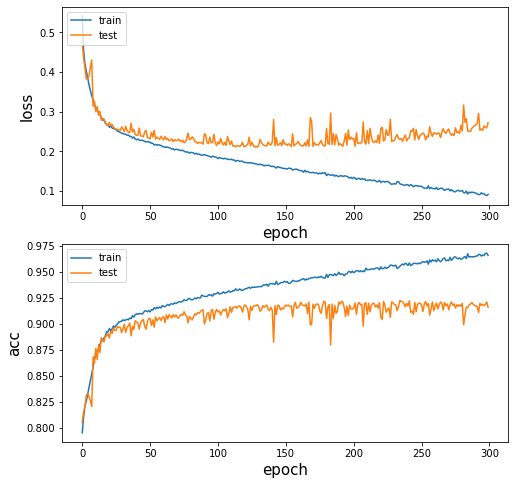

In [8]:
fig, ax = plt.subplots(2,1,figsize=(8, 8))
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].legend(["train", "test"], loc="upper left")
ax[0].set_xlabel("epoch", fontsize=15)
ax[0].set_ylabel("loss", fontsize=15)

ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].legend(["train", "test"], loc="upper left")
ax[1].set_xlabel("epoch", fontsize=15)
ax[1].set_ylabel("acc", fontsize=15)
#plt.savefig("../outputs/lossaccCPUJGPUTAC_modelA*_normadata.pdf",bbox_inches="tight")

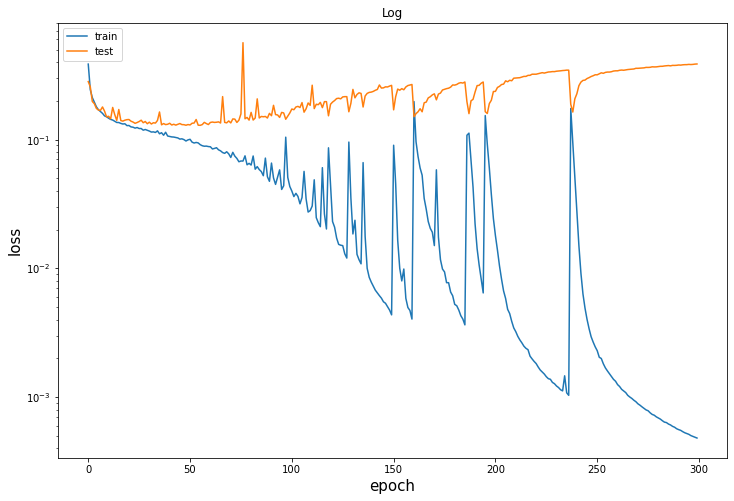

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.legend(["train", "test"], loc="upper left")
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
ax.set_yscale('log')
ax.set_title('Log')
plt.show()

test = None
test_targ = None
test_ID = None

In [10]:
test = np.zeros((183143,51,153))
test_targ = np.zeros((183143))
test_ID = np.zeros((183143))
init_len_te = 0
for ii in range(10): 
    times = 0
    start = 0
    end = 0

    start = time.time()
    print("Star with {}".format(ii))
    test_1 = np.load('../data/data_split/test%d'%ii+'.npy') 
    test_targ_1 = np.load('../data/data_split/test_targ_%d'%ii+'.npy')
    test_id_1 = np.load('../data/data_split/test_ID_%d'%ii+'.npy')
    feat_te2_1 = test_1.reshape(len(test_1), 51, 153, 1)
    loss_te_1, acc_te_1 = model.evaluate(feat_te2_1, test_targ_1,verbose=False)
    print("Testing_%d"%ii+"accuracy : {0:.4f}".format(acc_te_1))
    print('unique test: {}'.format(np.unique(test_targ_1, return_counts=True)))
    
    test[init_len_te:init_len_te+len(test_1)] = test_1
    test_targ[init_len_te:init_len_te+len(test_1)] = test_targ_1
    test_ID[init_len_te:init_len_te+len(test_1)] = test_id_1
    init_len_te = init_len_te + len(test_1)
    
    test_1 = None
    test_targ_1 = None
    test_id_1 = None
    feat_te2_1 = None
    

    end = time.time()
    times  = (end - start)
    print(times)
    
feat_te2 = test.reshape(len(test), 51, 153, 1)

Star with 0
Testing_0accuracy : 0.9520
unique test: (array([0, 1]), array([8373, 8367]))
9.007148027420044
Star with 1
Testing_1accuracy : 0.9534
unique test: (array([0, 1]), array([8686, 8659]))
9.822106122970581
Star with 2
Testing_2accuracy : 0.9567
unique test: (array([0, 1]), array([9878, 9866]))
11.252487182617188
Star with 3
Testing_3accuracy : 0.9521
unique test: (array([0, 1]), array([9572, 9454]))
10.586698293685913
Star with 4
Testing_4accuracy : 0.9535
unique test: (array([0, 1]), array([11059, 11009]))
12.433116912841797
Star with 5
Testing_5accuracy : 0.9531
unique test: (array([0, 1]), array([8681, 8607]))
10.607178211212158
Star with 6
Testing_6accuracy : 0.9532
unique test: (array([0, 1]), array([9071, 8987]))
10.306723833084106
Star with 7
Testing_7accuracy : 0.9519
unique test: (array([0, 1]), array([9921, 9977]))
11.430559158325195
Star with 8
Testing_8accuracy : 0.9542
unique test: (array([0, 1]), array([11158, 11177]))
12.626407623291016
Star with 9
Testing_9accur

LOAD ID

In [11]:
#train_ID = train_ID.astype(int)
test_ID = test_ID.astype(int)
#train_targ = train_targ.astype(int)
test_targ = test_targ.astype(int)

In [12]:
# df_train = pd.DataFrame({'ID':train_ID, 'OBJECT_TYPE':train_targ})
# df_train

In [13]:
# y_pred_train = model.predict(feat_tr2)
# df_train["predicted"] = np.argmax(y_pred_train,axis=1)

In [14]:
df_test = pd.DataFrame({'ID':test_ID, 'OBJECT_TYPE':test_targ})
df_test

,ID,OBJECT_TYPE
0,6960249,1
1,6961342,1
2,6961400,0
3,6961853,1
4,6962070,1
...,...,...
183138,11872858,1
183139,11873091,0
183140,11873778,0
183141,11873897,0


In [1]:
y_pred_test = loaded_model.predict(feat_te2)
df_test["predicted"] = np.argmax(y_pred_test,axis=1)

NameError: name 'model' is not defined

In [ ]:
df_test

In [ ]:
df_test_mssbogus = df_test[(df_test["OBJECT_TYPE"] == 1) & (df_test["predicted"] == 0)]
print(len(df_test_mssbogus))

In [ ]:
# fig, ax = plt.subplots(14,3, figsize = (15,45))
# #fig.subplots_adjust(0, 0, 0.5, 1, 0, 1)

# for i in range(14*3):
#     ax[i//3,i%3].axis("off")
#     ax[i//3,i%3].imshow(test[df_test_mssbogus.index.to_numpy()[i]])
#     ax[i//3,i%3].set_title("{}".format(df_test_mssbogus.loc[df_test_mssbogus.index.to_numpy()[i]]["ID"]), fontsize = 10)  
# #plt.savefig("testss.pdf",bbox_inches="tight")